In [1]:
import numpy as np
import pandas as pd
import json
import codecs
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

#Yenny's dups file
json_file = "/Users/kimia/Desktop/Work5/duplicates_batch_2018-05-18.json"
df = pd.read_json(json_file, lines=True)
dfsub = json_normalize(df.submission)

#everything but payload ('twas messy, so I split it then merge)
metadf = dfsub[[ 'task_id', 'updated_at', 'user_id', 'created_at', 'id']]
dfsub = pd.DataFrame(dict(df.submission[0:])).T
dfpayloads = pd.DataFrame()

# I know this isn't efficient. But it helps split out the payloads (multiple per task_id). 
for i in range(dfsub.shape[0]):
    f = pd.DataFrame(dfsub.payload[i]).T
    f['id'] = dfsub.id[i]
    f['task_id'] = dfsub.task_id[i]
    f['user_id'] = dfsub.user_id[i]
    f['created_at'] = dfsub.created_at[i]
    f['updated_at'] = dfsub.updated_at[i]
    dfpayloads = pd.concat([dfpayloads, f])
    
dfpayloads = dfpayloads.reset_index()
dfpayloads = dfpayloads.rename(index=str, columns={"index": "payload"})
dfpayloads['count'] = 1 # this is to signify one input per user
#dfpayloads.to_csv('dfpayloads.csv')


In [103]:
all_probabilities = pd.DataFrame()

#probabilities of 4
for i,sample in enumerate([2,3,4,5]):
    df = dfpayloads[dfpayloads['annotation']!= "unsure"]

    df['unique'] = (df.task_id).apply(lambda x: str(x)) + (df.payload).apply(lambda x: str(x))

    df2 = df.groupby('unique').size().to_frame().reset_index()
    df2 = (df2[df2[0]>4])
    df5 = pd.merge(df2, df, on = 'unique')


    ## take a sample
    dfsample4 = df5.groupby('unique').apply(lambda x: (x.sample(int(sample)))).reset_index(drop=True)
    # make duplicate means 1 if dup, else = 0
    dfsample4["dup"] = 0
    dfsample4.loc[dfsample4['annotation'] == 'duplicate', 'dup'] = 1
    # get the ratio of consensus
    prob = dfsample4.groupby('unique').apply(lambda x: (np.sum(x['dup'])/int(sample))).reset_index(drop=True)

    # only where everyone totally agrees. 
    probabilities = pd.DataFrame(prob)
    probabilities['sample'] = int(sample)
    probabilities['consensus'] = 0
    probabilities.loc[probabilities[0] == 0, 'consensus'] = 1
    probabilities.loc[probabilities[0] == 1, 'consensus'] = 1
    all_probabilities = pd.concat([all_probabilities, probabilities], axis = 0)



In [107]:
for i,sample in enumerate([2,3,4,5]):
    d = (all_probabilities[all_probabilities['sample']== int(sample)])
    print(sample, d['consensus'].mean())

2 0.9634175837465232
3 0.9461240778812432
4 0.9344842181642279
5 0.9243862619421938


In [162]:
#https://www.thomasjpfan.com/2015/09/bayesian-coin-flips/
def plot_posterior(heads, tails, alpha, beta, ax=None):
    x = np.linspace(0, 1, 1000)
    y = scipy.stats.beta.pdf(x, heads+alpha, tails+beta) 
    
    #params1= np.array( [2.,2.] ) +  np.array( [heads, len(d.consensus)] )
    #y1 = beta.pdf( x, *params1)
    
    if not ax:
        fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(r"$\theta$", fontsize=20)
    ax.set_ylabel(r"$P(\theta|D)$", fontsize=20)
    ax.set_title("Posterior after {} consensus, {} divergences, \
                 Prior: BetaPDF({},{})".format(heads, tails, alpha, beta));

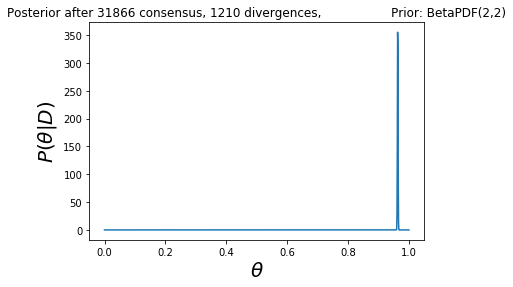

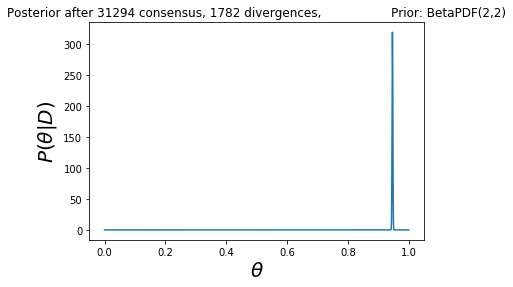

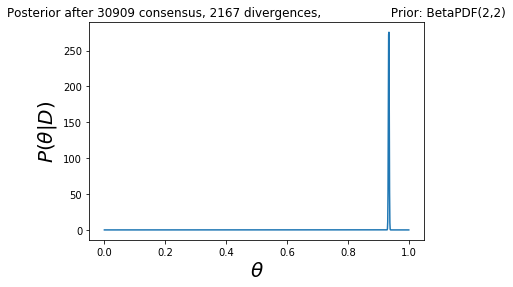

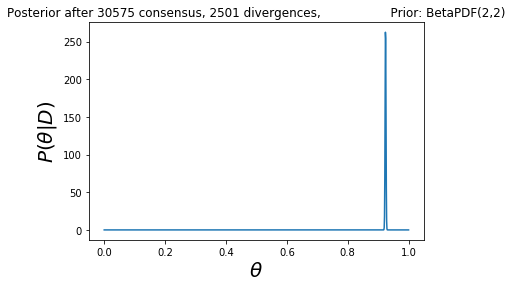

In [163]:
import scipy
for i,sample in enumerate([2,3,4,5]):
    d = (all_probabilities[all_probabilities['sample']== int(sample)])

    plot_posterior(np.sum(d.consensus), (len(d.consensus)-np.sum(d.consensus)), 2, 2)
    #print(sample, d['consensus'].mean())

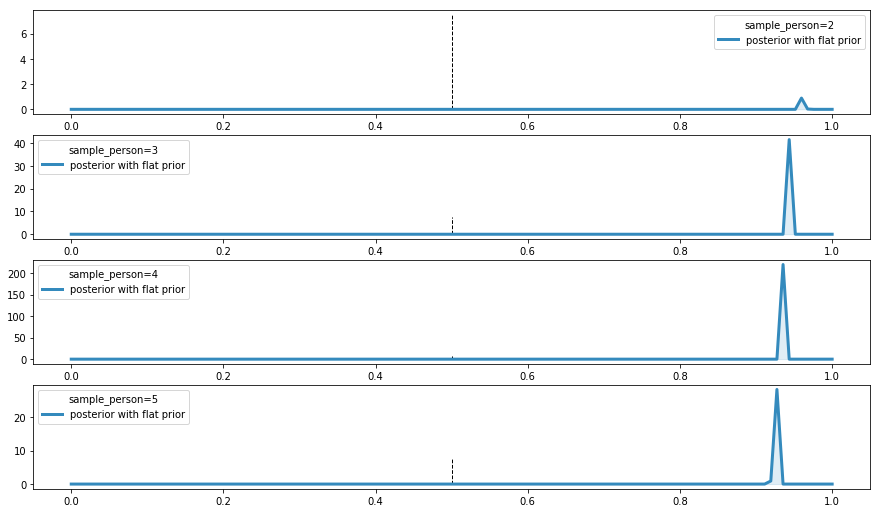

In [145]:
import scipy.stats as stats

plt.figure(figsize=( 15, 18))

p = 0.5
beta1_params = np.array( [2,2] )  # FLAT 
beta = stats.beta 

x = np.linspace(0.00, 1, 125)
#data = stats.bernoulli.rvs(p=.5,size=500)   #LIKELIHOOD

for i,Sample in enumerate([2,3,4,5]):
    d = (all_probabilities[all_probabilities['sample']== int(Sample)])
    data = d.consensus # LIKELIHOOD 
    s = data.sum() 
    plt.subplot(8,1,i+1)
    beta = stats.beta 
    
    params1 = beta1_params + np.array( [s, (len(data))-s] )    # posteriors beta parameters

    x = np.linspace(0.00, 1, 125)
    y1 = beta.pdf( x, *params1)  # the posterior 
    plt.plot(x,y1, label = r"posterior with flat prior", lw =3, color ="#348ABD" )
   
    plt.fill_between( x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.legend(title = "sample_person=%d"%Sample)
    plt.vlines( .5, 0.0, 7.5, linestyles = "--", linewidth=1)
    #plt.ylim( 0, 10)#

In [165]:
dfsample4.groupby('unique').apply(lambda x: (np.sum(x['dup'])/int(sample))).reset_index(drop=True)


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        1.0
8        0.0
9        0.0
10       0.0
11       0.0
12       0.0
13       0.0
14       0.0
15       0.0
16       0.0
17       0.2
18       0.0
19       0.0
20       1.0
21       0.2
22       0.0
23       0.2
24       0.0
25       0.0
26       0.0
27       1.0
28       0.0
29       0.0
        ... 
33046    0.0
33047    0.0
33048    1.0
33049    0.0
33050    0.0
33051    0.0
33052    0.0
33053    0.0
33054    0.0
33055    1.0
33056    0.0
33057    0.0
33058    0.0
33059    0.0
33060    0.0
33061    0.0
33062    0.0
33063    0.0
33064    0.0
33065    0.8
33066    0.0
33067    0.0
33068    0.0
33069    0.0
33070    0.0
33071    0.0
33072    0.0
33073    0.0
33074    0.0
33075    0.0
Length: 33076, dtype: float64

In [2]:
df = dfpayloads
df['unique'] = (df.task_id).apply(lambda x: str(x)) + (df.payload).apply(lambda x: str(x))


In [50]:
print(len(['565989764981e-99f7-49ce-9e25-3d2c9959bd66', '56601e4d1cb3c-f077-45ff-ac93-758dc65281b2', '56597e823c86d-7f57-4e63-9857-d1b968b1e7c3', '565935cfbbd90-81a1-4d82-94f4-a62fc08cb51e', '565964ac1b6bb-5f02-49b4-a66d-130ee4022d09', '56598db408bb6-858f-41c7-9e47-67b03fb6860b', '565935cfbbd90-81a1-4d82-94f4-a62fc08cb51e','565929a5d1cb5-d8a8-4964-b2ea-b4428f5a2708','565961cb3a5d4-369a-4e49-afed-52b0fc427579', '565950cdec060-2c1f-4f48-b254-8526f6f8cc0c','59032f77a55f5-0ef7-47b1-bb9c-9fddad63cbf7', '5659242714808-8c62-48e4-b564-898476195788','5659286b9a2ed-905a-4e1b-9437-257b3000b9ce', '5659286b9a2ed-905a-4e1b-9437-257b3000b9ce',"565923547e0aa-9f2a-4e65-8ab1-da5831b4d379", "56592d74fc8fc-14de-4e5b-98c9-d24b0215af07"])
)
df[467:]
df[df.unique == '565989764981e-99f7-49ce-9e25-3d2c9959bd66']

16


,payload,annotation,created_at,id,task_id,updated_at,user_id,count,unique
424,9764981e-99f7-49ce-9e25-3d2c9959bd66,non-duplicate,2018-05-15T18:42:15.748Z,158551,56598,2018-05-15T18:43:38.642Z,40,1,565989764981e-99f7-49ce-9e25-3d2c9959bd66
436,9764981e-99f7-49ce-9e25-3d2c9959bd66,non-duplicate,2018-05-03T19:20:26.207Z,145914,56598,2018-05-03T19:32:08.299Z,44,1,565989764981e-99f7-49ce-9e25-3d2c9959bd66
448,9764981e-99f7-49ce-9e25-3d2c9959bd66,non-duplicate,2018-05-03T19:21:17.618Z,145917,56598,2018-05-03T19:26:17.537Z,46,1,565989764981e-99f7-49ce-9e25-3d2c9959bd66
460,9764981e-99f7-49ce-9e25-3d2c9959bd66,non-duplicate,2018-05-03T19:21:10.450Z,145916,56598,2018-05-03T19:22:42.633Z,47,1,565989764981e-99f7-49ce-9e25-3d2c9959bd66
472,9764981e-99f7-49ce-9e25-3d2c9959bd66,non-duplicate,2018-05-03T19:20:45.484Z,145915,56598,2018-05-03T19:23:16.427Z,22,1,565989764981e-99f7-49ce-9e25-3d2c9959bd66


In [54]:
dfpayloads['unique'] = (dfpayloads.task_id).apply(lambda x: str(x)) + (dfpayloads.payload).apply(lambda x: str(x))


In [62]:

def consensus(df, column):
    lowagreement = df.groupby([ 'unique', str(column)]).size().to_frame(name = 'count').reset_index()
    agree5 = lowagreement[lowagreement['count'] >4]
    perc5 = (len(agree5.unique.unique())/len(dfpayloads.unique.unique()))
    accuracy = ({str(column):perc5})
    return accuracy
consensus(dfpayloads, 'annotation')

{'annotation': 0.911564017758708}

In [87]:
samplesize = 4
for i, v in enumerate([2,3,4,5]):
    samplesize = int(v)
    lowagreement = dfpayloads.groupby([ 'unique', str('annotation')]).size().to_frame(name = 'count').reset_index()
    agree5 = lowagreement[lowagreement['count'] == (int(samplesize))]
    perc5 = (len(agree5['unique'].unique())/len(lowagreement['unique'].unique()))
    accuracy = ({str('attribute'):perc5})
    print(v, accuracy)


2 {'attribute': 0.029230356663984984}
3 {'attribute': 0.030094454873215937}
4 {'attribute': 0.05586841870027711}
5 {'attribute': 0.8914513870266083}


In [88]:
agree5

,unique,annotation,count
0,5659205132050-c570-4f76-a3fe-7962271b866f,non-duplicate,5
1,5659221126bec-7c04-44a7-8fb2-1aec1dfd8e84,non-duplicate,5
2,565923547e0aa-9f2a-4e65-8ab1-da5831b4d379,non-duplicate,5
3,5659242714808-8c62-48e4-b564-898476195788,non-duplicate,5
4,565927e58fb9c-6979-486d-ae06-b2528c0651d6,non-duplicate,5
5,5659286b9a2ed-905a-4e1b-9437-257b3000b9ce,non-duplicate,5
6,565929a5d1cb5-d8a8-4964-b2ea-b4428f5a2708,non-duplicate,5
7,56592c5827784-7c2a-4dd9-b38d-fb956f226cb0,duplicate,5
8,56592d1139480-f5a9-4448-8ed2-6c13f1849432,non-duplicate,5
9,56592d57ca369-d6f1-4e1f-aae8-29e1bef3e9ca,non-duplicate,5


In [ ]:
def consensus(df, column, samplesize):
    lowagreement = df.groupby([ 'task_id', str(column)]).size().to_frame(name = 'count').reset_index()
    agree5 = lowagreement[lowagreement['count'] == samplesize]
    perc5 = (len(agree5.task_id.unique())/len(lowagreement.task_id.unique()))
    accuracy = ({str(column):perc5})
    return accuracy  
datafr =df 
datafr = datafr.groupby('unique').size().to_frame().reset_index()
datafr = (datafr[datafr[0]==5])
datafr = pd.merge(datafr,df, on ='unique',  how = 'left')


In [61]:
def consensus(df, column, samplesize):
    lowagreement = df.groupby([ 'task_id', str(column)]).size().to_frame(name = 'count').reset_index()
    agree5 = lowagreement[lowagreement['count'] == samplesize]
    perc5 = (len(agree5.task_id.unique())/len(lowagreement.task_id.unique()))
    accuracy = ({str(column):perc5})
    return accuracy  
datafr =df 
datafr = datafr.groupby('unique').size().to_frame().reset_index()
datafr = (datafr[datafr[0]==5])
datafr = pd.merge(datafr,df, on ='unique',  how = 'left')


columnsz = [
 'annotation']

samplesize = 5
datafr =df 
datafr = datafr.groupby('unique').size().to_frame().reset_index()
datafr = (datafr[datafr[0]==5])
datafr = pd.merge(datafr,df, on ='unique',  how = 'left')


final = pd.DataFrame()
accuracydict={}



for i, v in enumerate(columnsz): 
    df2 = datafr
    dfsample4 = df2.groupby(['unique']).apply(lambda x: (x.sample(int(samplesize)))).reset_index(drop=True)

    percent = (consensus(dfsample4, str(v), samplesize))
    accuracydict.update(percent)

all_perc_disagree = pd.Series(accuracydict).to_frame().sort_values([0],ascending = True)
final = pd.concat([all_perc_disagree, final], axis=1)
final['samplesize'] = samplesize
    #print("% disagreement by column in ",str(country[0:2]) )
print("    MODERATION: % there is consensus")
final5 = final
from IPython.core.display import HTML
display(HTML(((final).to_html())))

    MODERATION: % there is consensus


,0,samplesize
annotation,0.135316,5


In [ ]:
pd.concat([final5,final4,final3]).reset_index().sort_values(['index'])
dff = pd.concat([final5,final3]).reset_index().sort_values(['index'])
dff = dff.T
dff


In [ ]:
dff = dff[1:7]
dff['address'] = dff[0]-dff[4]
dff['website'] = dff[1]-dff[5]
dff['name'] = dff[2]-dff[6]
dff['tel'] = dff[3]-dff[7]
dff = (dff*-1)*100
print('% consensus gained by reducing \n annotation from 5 to 3')
dff[['address', 'website', 'name', 'tel']]

In [95]:
def probz(n, pc):
    probconsensatn = (pc**n + (1-pc)**n)
    return print(pc, n, probconsensatn)


In [97]:
probz(2, 0.9634175837465232)
probz(3, 0.9461240778812432)
probz(4, 0.9344842181642279)
probz(5, 0.9243862619421938)

0.9634175837465232 2 0.9295117138509317
0.9461240778812432 3 0.8470800785961686
0.9344842181642279 4 0.7626027684641463
0.9243862619421938 5 0.6749459608664039


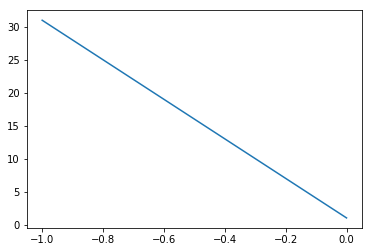

In [100]:
import numpy as np  
import matplotlib.pyplot as plt  
def graph(formula, x_range):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y)  
    plt.show()
graph('x**5 + (1-x)**5', range(-1, 1))